# Track filtering/fitting with LSTMs

This is a continuous space model using the ACTS data.

In this notebook we use data that was pre-processed from ACTS data with the prepareFilterData.py script.

In [1]:
# Select a GPU first
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '6'
os.environ['OMP_NUM_THREADS'] = '4'
cuda = False

In [2]:
from __future__ import print_function

# System imports
from timeit import default_timer as timer

# Data libraries
import numpy as np
import pandas as pd

# Torch imports
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

# Visualization
import matplotlib.pyplot as plt

# Local imports
import torchutils
torchutils.set_cuda(cuda)
from torchutils import np_to_torch, torch_zeros, torch_to_np
from estimator import Estimator

# Magic
%matplotlib notebook

## Read the data

In [3]:
data_dir = '/global/cscratch1/sd/sfarrell/heptrkx/RNNFilter'

In [4]:
train_data = np.load(os.path.join(data_dir, 'train_data.npy'))
test_data = np.load(os.path.join(data_dir, 'test_data.npy'))

## Define the model

We define an LSTM model in PyTorch which will predict the next hit location.

In [5]:
class TrackFilterer(nn.Module):

    def __init__(self, input_dim=3, hidden_dim=5, output_dim=2, n_lstm_layers=1):
        super(TrackFilterer, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_lstm_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        input_size = x.size()
        # Initialize the lstm hidden state
        h = (torch_zeros(self.lstm.num_layers, input_size[0], self.lstm.hidden_size),
             torch_zeros(self.lstm.num_layers, input_size[0], self.lstm.hidden_size))
        x, h = self.lstm(x, h)
        # Flatten layer axis into batch axis so FC applies independently across layers.
        x = (self.fc(x.contiguous().view(-1, x.size(-1)))
             .view(input_size[0], input_size[1], -1))
        return x

## Configure and train the model

In [6]:
# Model config
hidden_dim = 20
n_lstm_layers = 1

# Train config
n_epochs = 200
batch_size = 32

In [7]:
# Inputs are the hits from [0, N-1)
# Targets are the hits from [1, N) without the layer feature.
train_input = np_to_torch(train_data[:,:-1])
train_target = np_to_torch(train_data[:,1:,:2])
test_input = np_to_torch(test_data[:,:-1])
test_target = np_to_torch(test_data[:,1:,:2])

In [ ]:
# Construct the model and estimator
estimator = Estimator(
    TrackFilterer(hidden_dim=hidden_dim),
    loss_func=nn.MSELoss(), cuda=cuda)

TrackFilterer (
  (lstm): LSTM(3, 20, batch_first=True)
  (fc): Linear (20 -> 2)
)
Parameters: 2042


In [ ]:
%%time

# Train the model
estimator.fit(train_input, train_target,
              valid_input=test_input, valid_target=test_target,
              batch_size=batch_size, n_epochs=n_epochs)

<IPython.core.display.Javascript object>


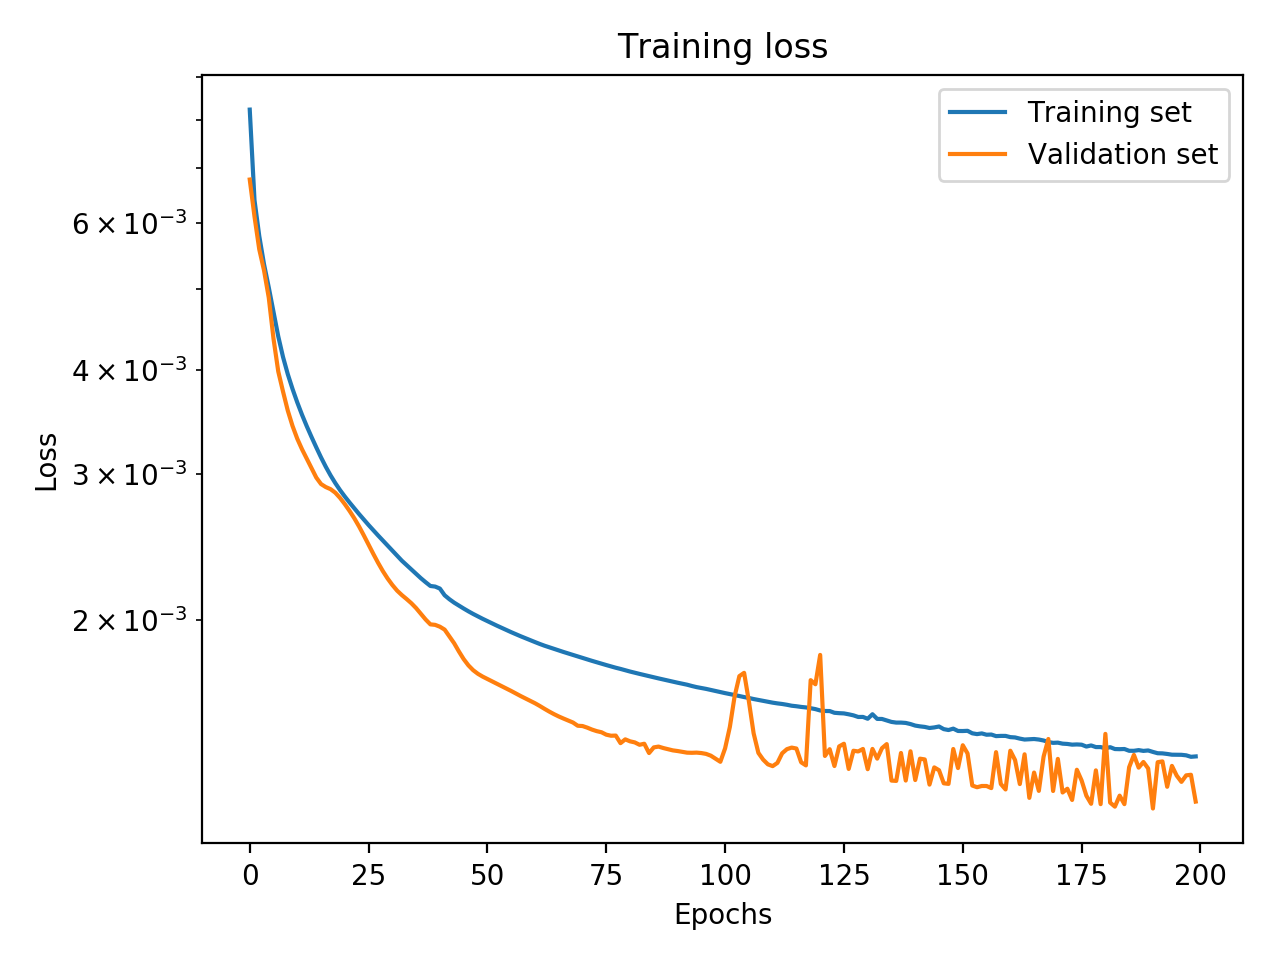

In [14]:
plt.figure()
epochs = np.arange(n_epochs)
plt.semilogy(epochs, np.array(estimator.train_losses), label='Training set')
plt.semilogy(epochs, np.array(estimator.valid_losses), label='Validation set')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training loss')
plt.legend(loc=0)
plt.tight_layout()

## Evaluate model performance

In [17]:
from track_filter.features import coord_scale

In [18]:
# Get the predictions and errors for the full training set
train_output = estimator.model(train_input)
train_error = train_output - train_target
train_resid = train_error.cpu().data.numpy() * coord_scale[:2]

# Get the predictions and errors for the full test set
test_output = estimator.model(test_input)
test_error = test_output - test_target
test_resid = test_error.cpu().data.numpy() * coord_scale[:2]

<IPython.core.display.Javascript object>


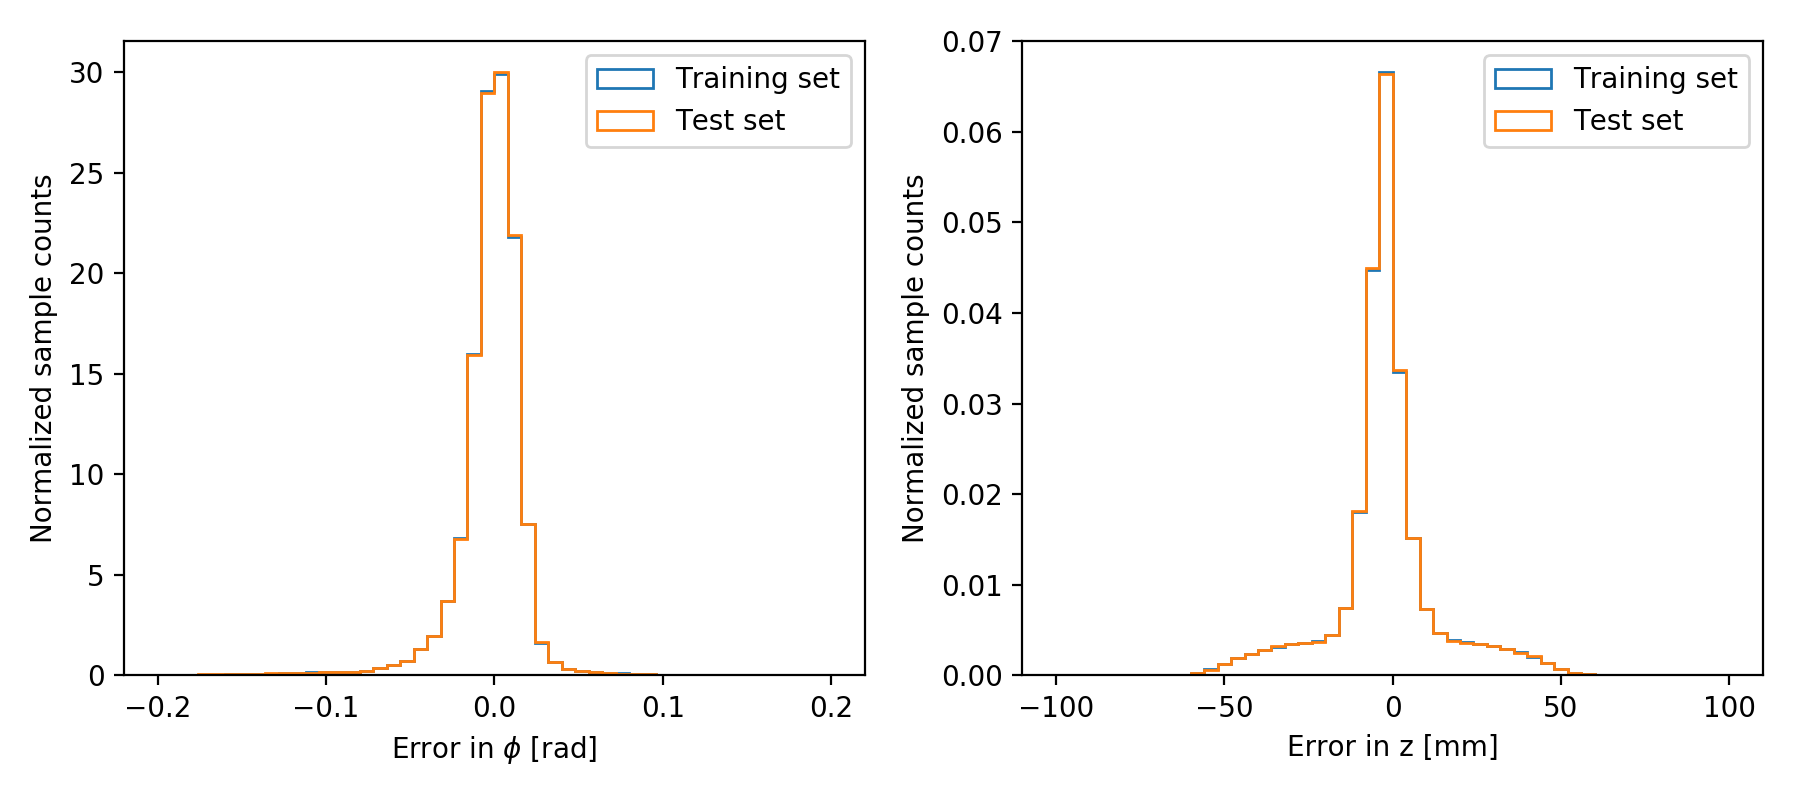

In [19]:
plt.figure(figsize=(9,4))
plt.subplot(121)
hist_args = dict(bins=50, range=(-0.2, 0.2), normed=True, log=False, histtype='step')
plt.hist(train_resid[:,:,0].flatten(), label='Training set', **hist_args)
plt.hist(test_resid[:,:,0].flatten(), label='Test set', **hist_args)
plt.xlabel('Error in $\phi$ [rad]')
plt.ylabel('Normalized sample counts')
plt.legend(loc=0)

plt.subplot(122)
hist_args = dict(bins=50, range=(-100, 100), normed=True, log=False, histtype='step')
plt.hist(train_resid[:,:,1].flatten(), label='Training set', **hist_args)
plt.hist(test_resid[:,:,1].flatten(), label='Test set', **hist_args)
plt.xlabel('Error in z [mm]')
plt.ylabel('Normalized sample counts')
plt.legend(loc=0)
plt.tight_layout()

#### Observations

- The $\phi$ residual has a funny asymmetric shape. Not sure what's going on there.
- Training and test set agree perfectly.
- Non-gaussian tails in the Z residual.

## Visualize trajectories

<IPython.core.display.Javascript object>


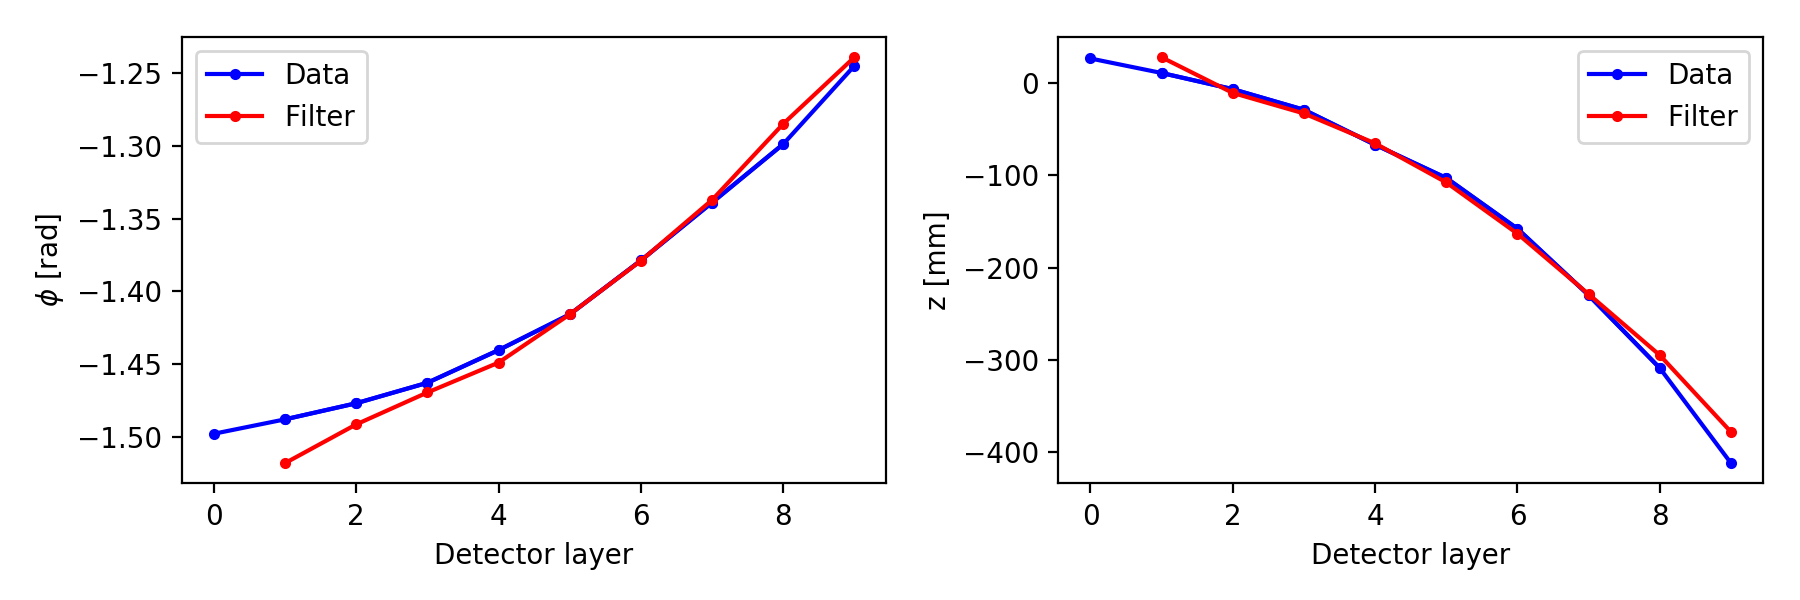

<IPython.core.display.Javascript object>


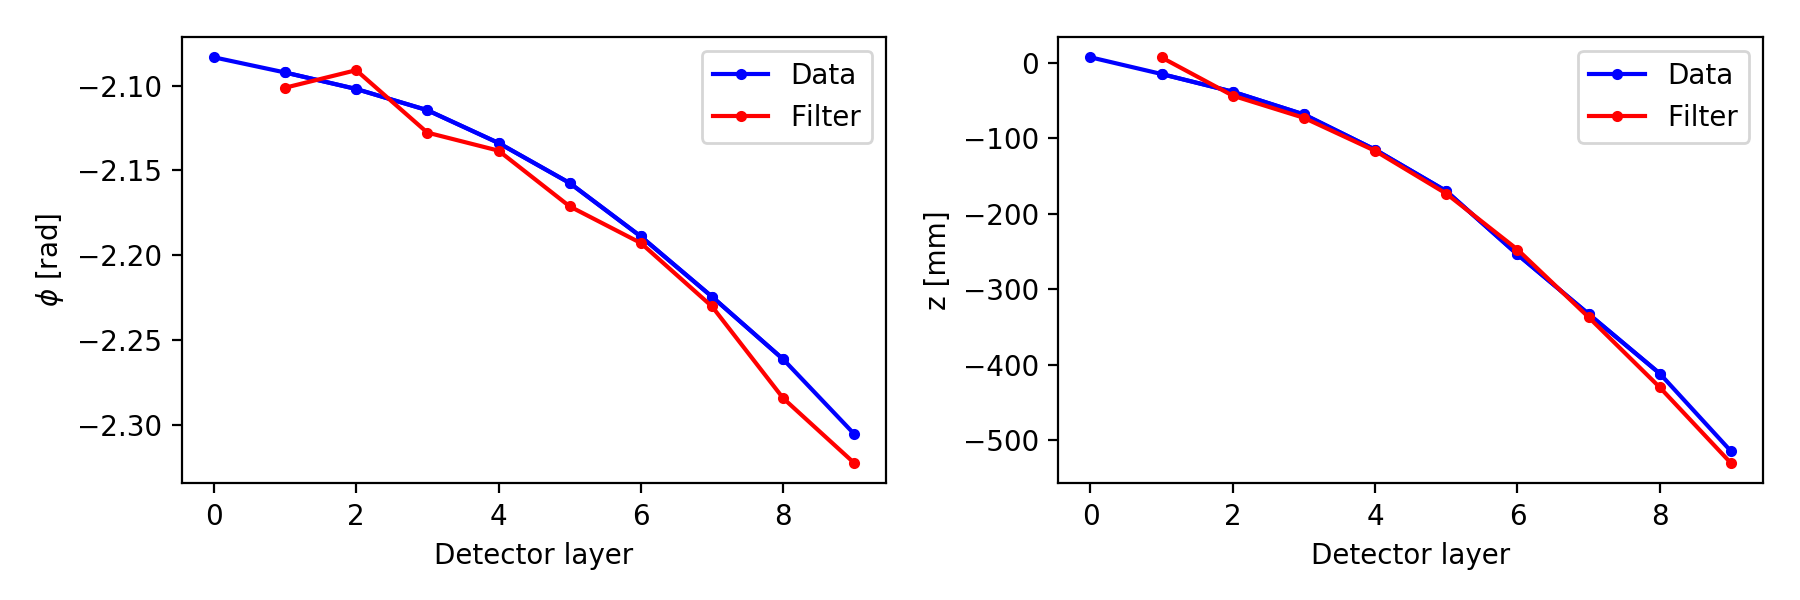

<IPython.core.display.Javascript object>


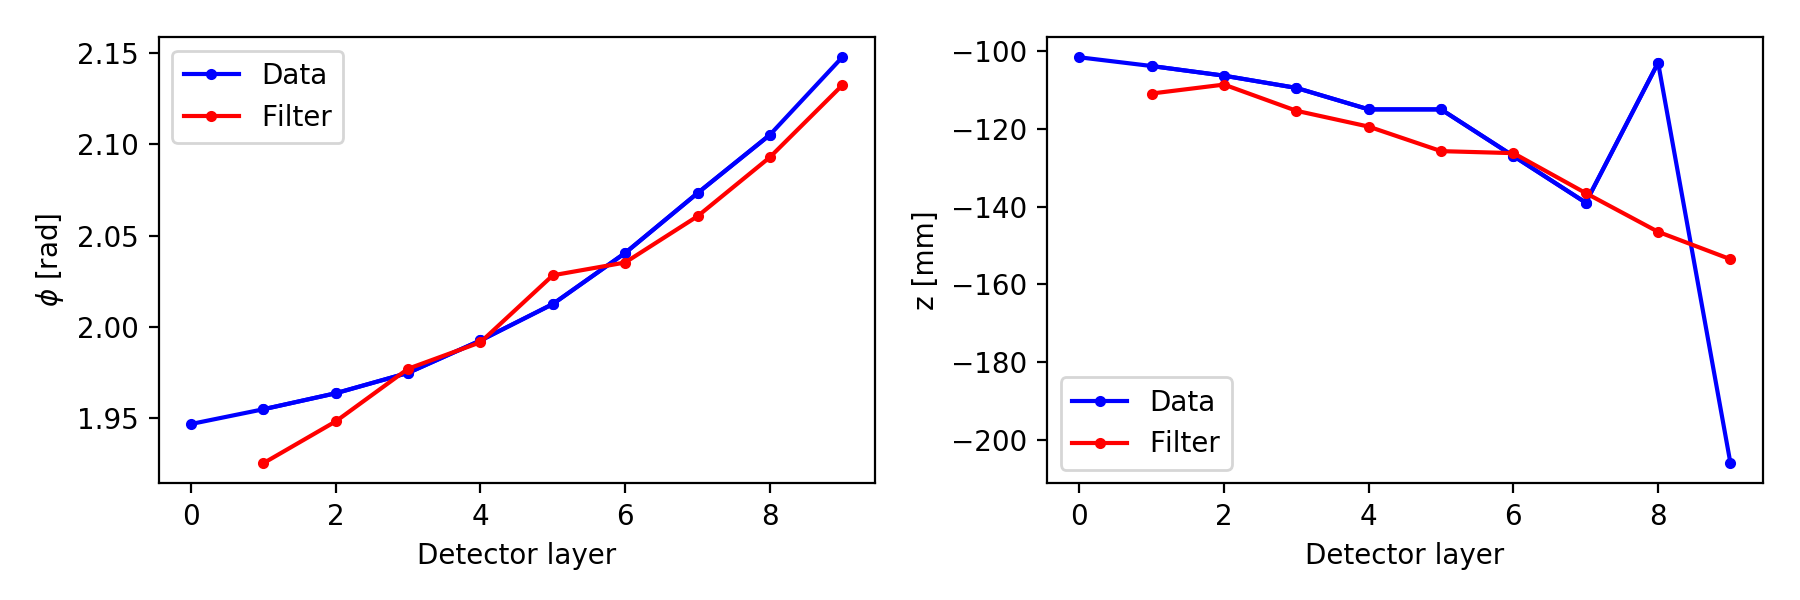

<IPython.core.display.Javascript object>


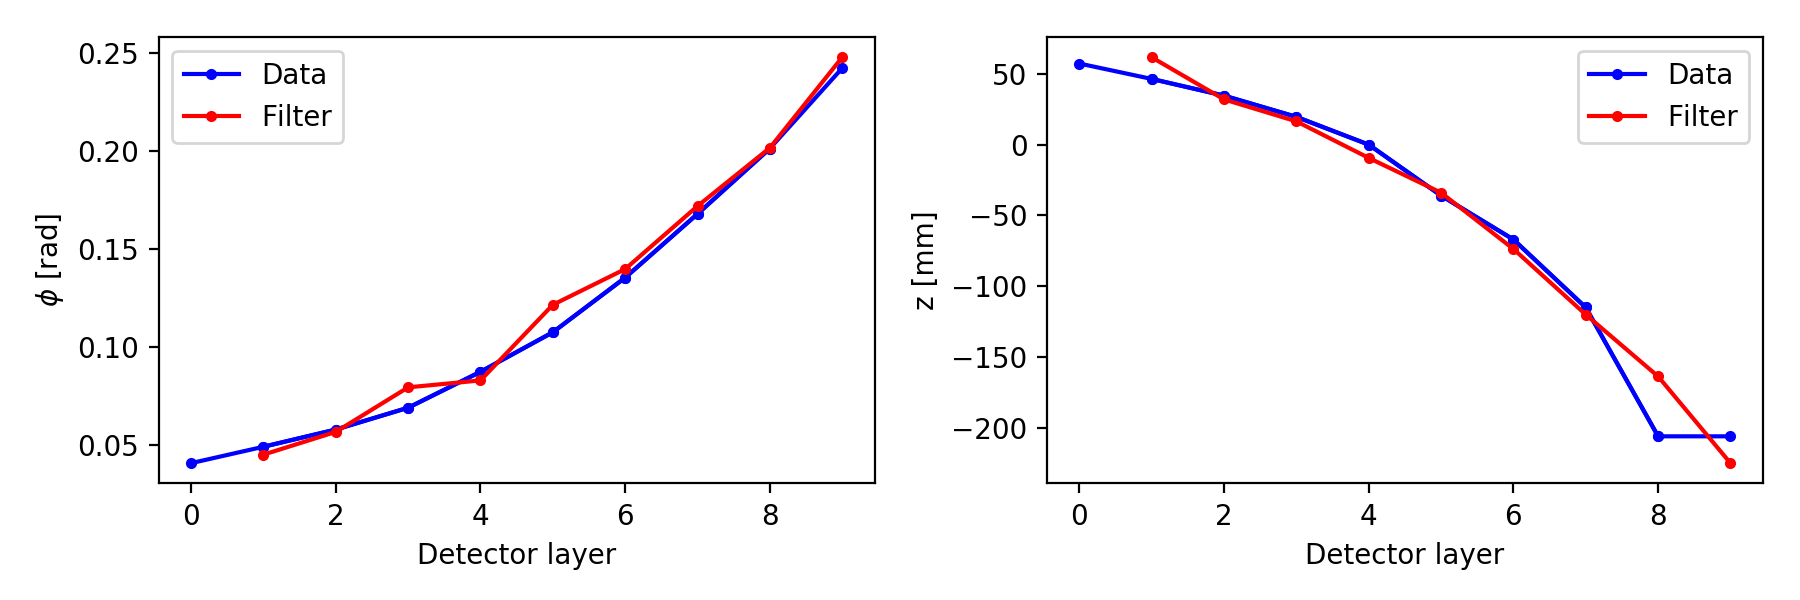

<IPython.core.display.Javascript object>


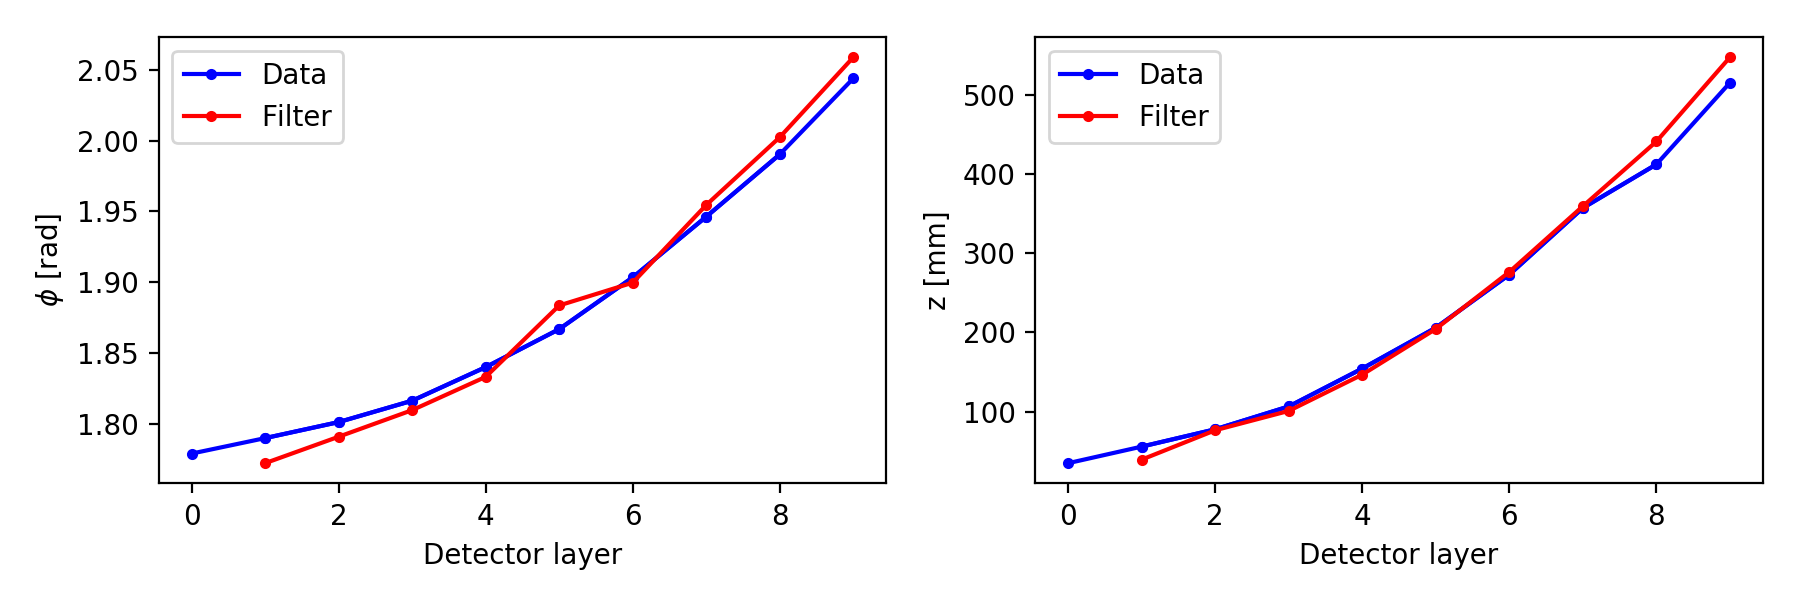

<IPython.core.display.Javascript object>


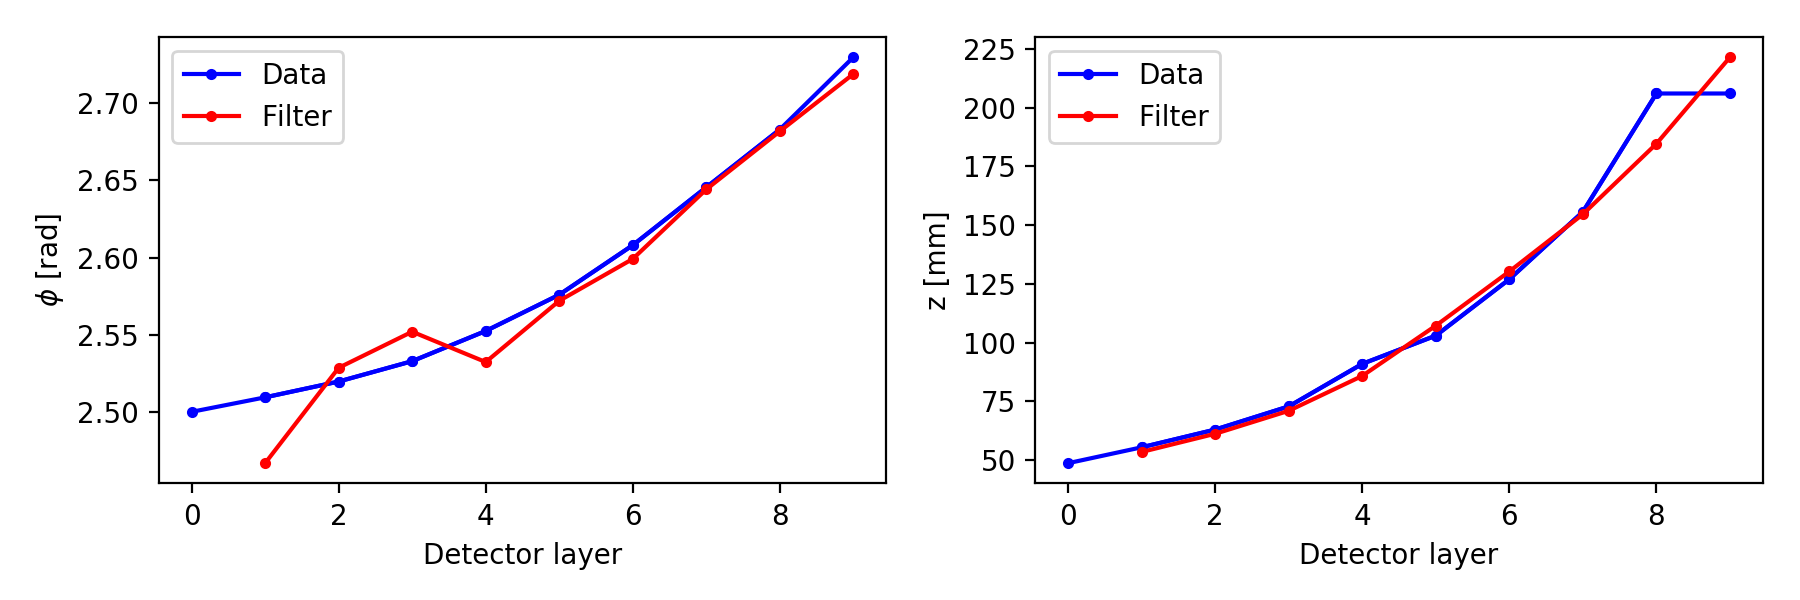

In [20]:
for i in range(6):
    layers = np.arange(10)
    inputs = test_input[i].cpu().data.numpy() * coord_scale
    outputs = test_output[i].cpu().data.numpy() * coord_scale[:2]
    targets = test_target[i].cpu().data.numpy() * coord_scale[:2]

    plt.figure(figsize=(9,3))

    plt.subplot(121)
    plt.plot(layers[:-1], inputs[:,0], 'b.-')
    plt.plot(layers[1:], targets[:,0], 'b.-', label='Data')
    plt.plot(layers[1:], outputs[:,0], 'r.-', label='Filter')
    plt.xlabel('Detector layer')
    plt.ylabel('$\phi$ [rad]')
    plt.legend(loc=0)

    plt.subplot(122)
    plt.plot(layers[:-1], inputs[:,1], 'b.-')
    plt.plot(layers[1:], targets[:,1], 'b.-', label='Data')
    plt.plot(layers[1:], outputs[:,1], 'r.-', label='Filter')
    plt.xlabel('Detector layer')
    plt.ylabel('z [mm]')
    plt.legend(loc=0)

    plt.tight_layout()

#### Observations

- Wrap-around at $\phi = \pi$ can screw up the filter (not currently shown).
- Filter is often smoother than data in the coarse outer layers.
- Few examples seem a bit unstable.